<span style="color:#26488F; font-size:30px; font-weight: bold;">  Predictive Maintenance Classification </span>

<html>
<body>
<div style="color:#435987;
            border-style: solid;
            border-radius: 25px;
            border-color: #435987;
            padding-left: 10px">
       
<span style="color:#26488F; font-size:20px; font-weight: bold;">  Brief Description </span><br>
    
This dataset reflects real predictive maintenance encountered in the industry with measurements from real equipment. The features description is taken directly from the dataset source. <br>
<br>
<span style="font-weight: bold;"> The six features are: </span> <br>
<li>Type: the quality of the product, consisting of a letter L, M, or H. Meaning low, medium, and high, respectively. <br>
<li>Air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K.<br>
<li>Process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature<br> plus 10 K.<br>
<li>Rotational speed [rpm]: calculated from power of 2860 W, overlaid with a normally distributed noise.<br>
<li>Torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.<br>
<li>Tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.<br>
<br>

<span style="font-weight: bold;"> The targets are: </span> <br>
<li>Target: failure or no failure (to perform binary classification).<br>
<li>Failure Type: type of failure (to perform multiclass classification).<br>

<br>
It also includes the following information, which is not useful for building the models:<br>
<li>UID: unique identifier ranging from 1 to 10000.<br>
<li>ProductID: the id of the product.<br>
    
</p>
</div>

</body>
</html>

<span style="color:#26488F; font-size:28px; font-weight: bold;">  Importing libraries </span> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier, EasyEnsembleClassifier
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, NearMiss, ClusterCentroids
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, roc_auc_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, roc_curve, precision_recall_curve
import pickle
sns.set()

<span style="color:#26488F; font-size:28px; font-weight: bold;">  Loading data and first impressions </span> 

In [2]:
raw_data = pd.read_csv('../input/machine-predictive-maintenance-classification/predictive_maintenance.csv')
df = raw_data.copy()
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [3]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


**Quick insights:** 
* There are 10.000 instances in the dataset
* The are no missing values (every feature has 10.000 observations)
* Target variable are ones and zeros
* UDI seems to be an index number
* Product ID is an identification number. Hence, it can be removed

In [4]:
# Checking unique values for 'UDI' and 'Product ID'
print(f"{df['UDI'].nunique()} unique values for 'UDI'")
print(f"{df['Product ID'].nunique()} unique value for 'Pruduct ID'")

10000 unique values for 'UDI'
10000 unique value for 'Pruduct ID'


In [5]:
# Dropping 'UDI' and 'Product ID' from the dataset
df.drop(['UDI', 'Product ID'], axis=1, inplace=True)

In [6]:
# Let's change the name of the columns.
df = df.rename(mapper={'Air temperature [K]': 'Air temperature',
                       'Process temperature [K]': 'Process temperature',
                       'Rotational speed [rpm]': 'Rotational speed',
                       'Torque [Nm]': 'Torque', 
                       'Tool wear [min]': 'Tool wear'}, axis=1)

In [7]:
# Taking a look at 'Failure Type' variable
df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

This target variable assumes six possible values: no failure, or five different types of failure.


**Quick insight:** We can see that the dataset is highly unbalanced. Let's further check that with the 'target' variable:


In [8]:
df['Target'].value_counts(normalize=True)

0    0.9661
1    0.0339
Name: Target, dtype: float64



The dataset is indeed very unbalanced. We will deal with that later on.
 

In [9]:
# Rechecking for missing values
df.isna().sum()

Type                   0
Air temperature        0
Process temperature    0
Rotational speed       0
Torque                 0
Tool wear              0
Target                 0
Failure Type           0
dtype: int64

In [10]:
df['Type'].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

'Type' assumes three possible values. Later on they will be hot or ordinal encoded.

In [11]:
# Taking a look at the data types
df.dtypes

Type                    object
Air temperature        float64
Process temperature    float64
Rotational speed         int64
Torque                 float64
Tool wear                int64
Target                   int64
Failure Type            object
dtype: object

'Type' and 'Failure Type' are strings.

<span style="color:#26488F; font-size:18px; font-weight: bold;">  Target variables </span>

There are two target variables: 'Target' and 'Failure Type'. Let's dig in a bit to check if everything is ok.

In [12]:
# Checking types of failure
df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

There are 5 types of failure + not failure.

Now, let's check if there are inconsistencies between 'Target' and 'Failure Type': 


In [13]:
df_failure = df[df['Target'] == 1]
df_failure['Failure Type'].value_counts()

Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: Failure Type, dtype: int64

**WARNING!!** 9 values are classified as failure in the 'Target' variable but as No Failure in the 'Failure Type' variable. Let's check in the dataset:

In [14]:
df_failure[df_failure['Failure Type'] == 'No Failure']

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type
1437,H,298.8,309.9,1439,45.2,40,1,No Failure
2749,M,299.7,309.2,1685,28.9,179,1,No Failure
4044,M,301.9,310.9,1419,47.7,20,1,No Failure
4684,M,303.6,311.8,1421,44.8,101,1,No Failure
5536,M,302.3,311.8,1363,54.0,119,1,No Failure
5941,L,300.6,310.7,1438,48.5,78,1,No Failure
6478,L,300.5,309.8,1663,29.1,145,1,No Failure
8506,L,298.4,309.6,1710,27.3,163,1,No Failure
9015,L,297.2,308.1,1431,49.7,210,1,No Failure



It could go both ways, either failure or no failure. I think it would make sense to remove those instances since I do not know the real target here.


In [15]:
index_possible_failure = df_failure[df_failure['Failure Type'] == 'No Failure'].index
df.drop(index_possible_failure, axis=0, inplace=True)



Let's check the same but for 'Target' variable equal to zero (no failure):
    

In [16]:
df_failure = df[df['Target'] == 0]
df_failure['Failure Type'].value_counts()

No Failure         9643
Random Failures      18
Name: Failure Type, dtype: int64

**Second warning!!** Similarly, we have 18 instances classifed as Random Failures by 'Failure Type', whereas they are classifed as No failure by the 'Target Variable'. These 18 instances are in fact all instaces of 'Random Failures'.
Again, let's check and remove those instances as we do not really know if they belong to Failure class or not. Hence, we will end up with 4 types of failures since 'Random Failures' will be removed altogether.

In [17]:
df_failure[df_failure['Failure Type'] == 'Random Failures']

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type
1221,M,297.0,308.3,1399,46.4,132,0,Random Failures
1302,L,298.6,309.8,1505,45.7,144,0,Random Failures
1748,H,298.4,307.7,1626,31.1,166,0,Random Failures
2072,L,299.6,309.5,1570,35.5,189,0,Random Failures
2559,L,299.3,309.0,1447,50.4,140,0,Random Failures
3065,M,300.1,309.2,1687,27.7,95,0,Random Failures
3452,H,301.6,310.5,1602,32.3,2,0,Random Failures
5471,L,302.7,312.3,1346,61.2,170,0,Random Failures
5489,L,302.6,312.1,1499,35.0,215,0,Random Failures
5495,H,302.9,312.5,1357,55.0,12,0,Random Failures


In [18]:
index_possible_failure = df_failure[df_failure['Failure Type'] == 'Random Failures'].index
df.drop(index_possible_failure, axis=0, inplace=True)

27 instaces were removed (0.27% of the entire dataset). Of which:
   * 9 belonged to class **Failure in 'Target'** variable and **No failure in target 'Failure Type'**
   * 18 belonged to class **No failure in 'Target'** variable and **Random failures in target 'Failure Type'**

In [19]:
# We can check that all 27 instances were removed from the dataset:
df.shape[0]

9973

In [20]:
# Let's reset the index
df.reset_index(inplace=True, drop=True)

<span style="color:#26488F; font-size:28px; font-weight: bold;">  Explanatory Data Analysis (EDA) </span>

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Correlation </span>

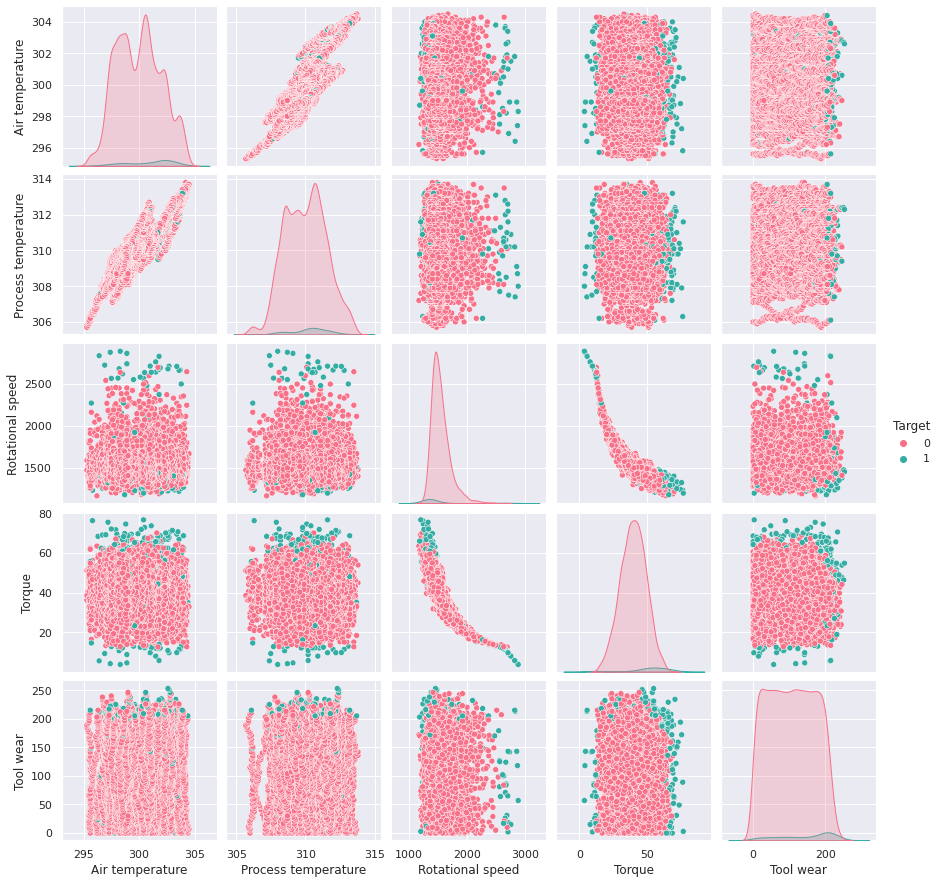

In [21]:
sns.pairplot(df, hue='Target', palette='husl')

**Insights:** 
* Torque and rotational speed are highly correlated.
* Process temperature and air temperature are also highly correlated.
* We immediately see that failures occur for extreme values of some features, i.e., the machinery fails either for the lowest or largest values of torque and rotational speed. This is easily spotted in the graph since the green dots are far apart for those features. So, there is a range for normal conditions in which the machines operate, and above or under this range, they tend to fail.

Let's plot a violin chart to see how torque and rotational speed behave:

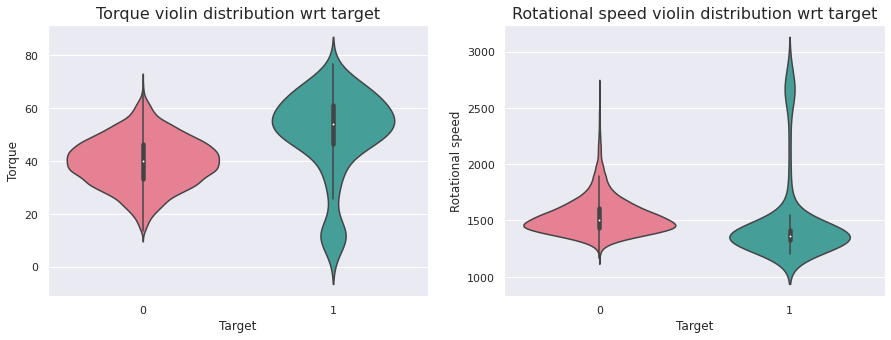

In [22]:
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16

fig, axes = plt.subplots(1, 2, figsize=[15,5])
axes = axes.flatten()
j=0

for i in ['Torque', 'Rotational speed']:
    sns.violinplot(data=df, x='Target', y=i, ax=axes[j], palette='husl')
    axes[j].set_title(i + ' violin distribution wrt target', )
    j += 1

**Insight:** Regarding torque and rotational speed, it can be seen again that most failures are triggered for much lower or much higher values than the mean when not failing.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Percentage of failure </span>

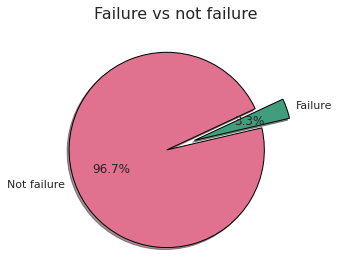

In [23]:
colors = ['#E1728F', '#409E7D'] 
plt.pie(df['Target'].value_counts(),  explode=[0.1, 0.2], labels=['Not failure', 'Failure'],
        autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25,
        colors=colors)
plt.title('Failure vs not failure')
plt.tight_layout()
plt.show()

**Insight:** as mentioned before, highly unbalanced dataset.

<span style="color:#26488F; font-size:22px; font-weight: bold;"> Correllation Heatmap </span>

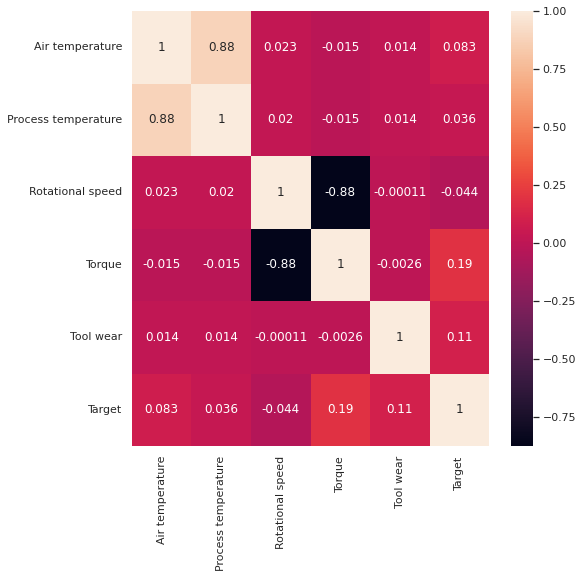

In [24]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True)
plt.show()

As mentioned before, there is high correlation between process temperature and air temperature, and between rotational speed and torque.


<span style="color:#26488F; font-size:22px; font-weight: bold;">  Product types </span>

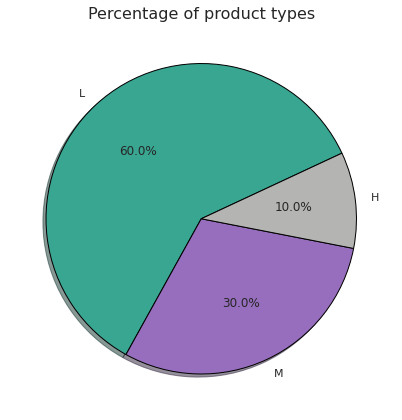

In [25]:
plt.rcParams["figure.figsize"] = (6,6)
colors = ['#39A692', '#976EBD', '#B4B5B2']
plt.pie(df['Type'].value_counts(), labels=['L', 'M', 'H'], colors=colors,
    autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25)

plt.title('Percentage of product types')
plt.tight_layout()

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Percentage of failure wrt product type </span>

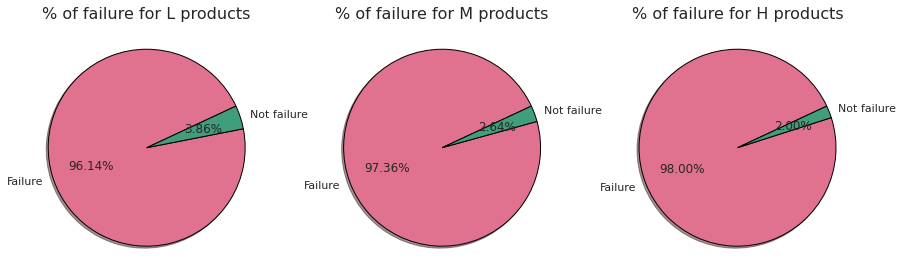

In [26]:
fig, axes = plt.subplots(1,3, figsize=[15,5])
axes.flatten()
j=0
colors = ['#E1728F', '#409E7D'] 
for i in ['L', 'M', 'H']:
    df_product_type = df[df['Type'] == i]
    axes[j].pie(df_product_type['Target'].value_counts(), labels=['Failure', 'Not failure'],
                autopct='%1.2f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25,
                colors=colors)
    axes[j].set_title('% of failure for ' + i + ' products')
    j+=1

**Insight:** L products have a higher ratio of failure compared to the other product types. Moreover, M tends to fail more than H products.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Percentage of failure types </span>

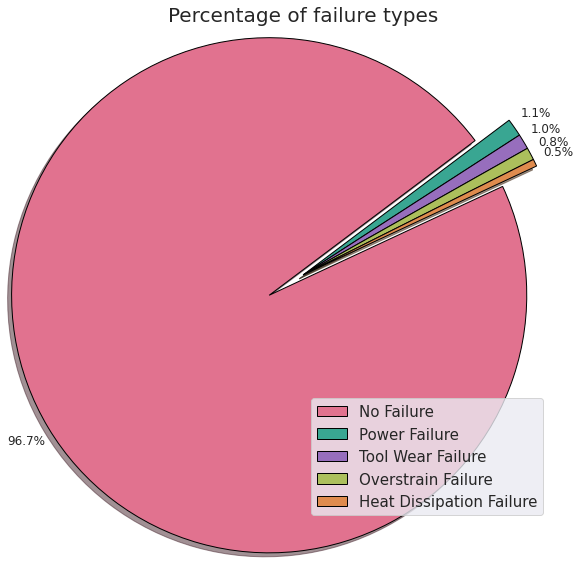

In [27]:
columns_failure_type = df['Failure Type'].unique().tolist()  # Types of failures

plt.rcParams["figure.figsize"] = (8,8)
colors = ['#E1728F', '#39A692', '#976EBD', '#ACBF5C', '#DF8B4E']

plt.pie(df['Failure Type'].value_counts(), explode=(0.2, 0, 0, 0, 0), autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'}, counterclock=False, shadow=True, startangle=25,
        pctdistance=1.1, radius=1.3, colors=colors)
plt.legend(columns_failure_type, loc='lower right', fontsize=15)

plt.title('Percentage of failure types', fontsize=20)
plt.tight_layout()

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Exploring features for each type of failure </span>

Text(0.5, 1.0, 'Excluding class no failure')

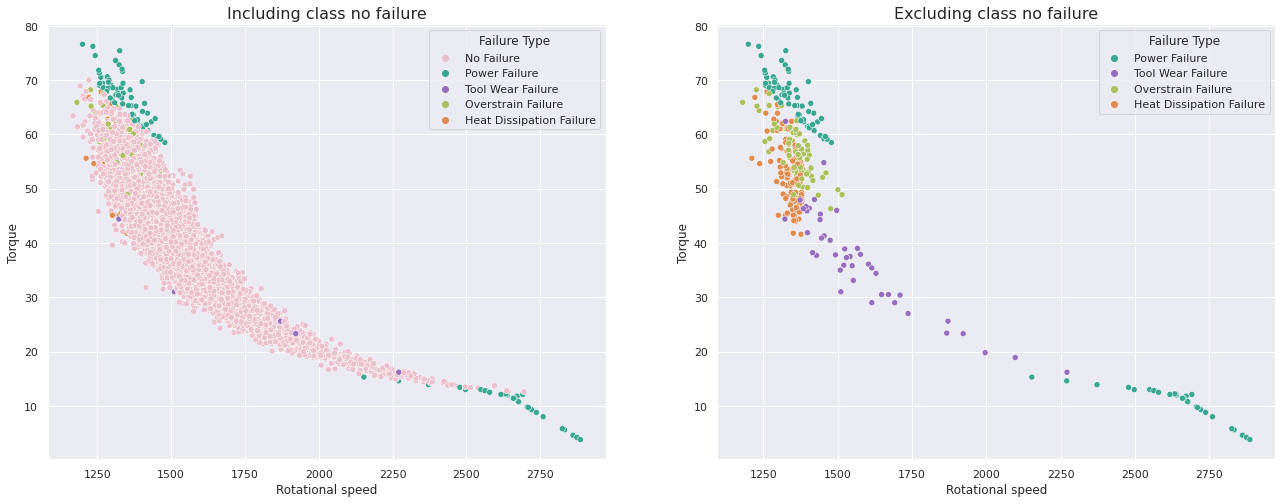

In [28]:
fig, ax = plt.subplots(1,2, figsize=[22,8])
plt.title('Rot. Speed vs Torque wrt Failure Type')
sns.scatterplot(data=df, x='Rotational speed', y='Torque', hue='Failure Type', palette=['#E9C0CB', '#39A692', '#976EBD', '#ACBF5C', '#DF8B4E'], ax=ax[0])
sns.scatterplot(data=df[df['Target'] == 1], x='Rotational speed', y='Torque', hue='Failure Type', palette=['#39A692', '#976EBD', '#ACBF5C', '#DF8B4E'], ax=ax[1])

ax[0].set_title('Including class no failure')
ax[1].set_title('Excluding class no failure')

**Some insights:**
* Power failure happens both for lower and higher rotational speed/torque. It is the type of failure with the highest rotational speed (over 2500rpm) and lowest torque (below around 15Nm). In other others, above and below these thresholds only power failures occur. 
* Between torques 16Nm and 41Nm all failures are tool wear. 
* Overstrain failures take place with torques ranging from around 47 and 68Nm) and rotational speeds from 1200 to 1500rpm approximately.
* For heat dissipation failures, the torque range is smaller and the rotational speed range is bigger compared to overstrain failures.



<span style="color:#26488F; font-size:22px; font-weight: bold;">  Distribution </span> 

----- SKEWNESS ------------
Air temperature skewness = 0.12
Process temperature skewness = 0.02
Rotational speed skewness = 1.99
Torque skewness = -0.01
Tool wear skewness = 0.03
---------------------------


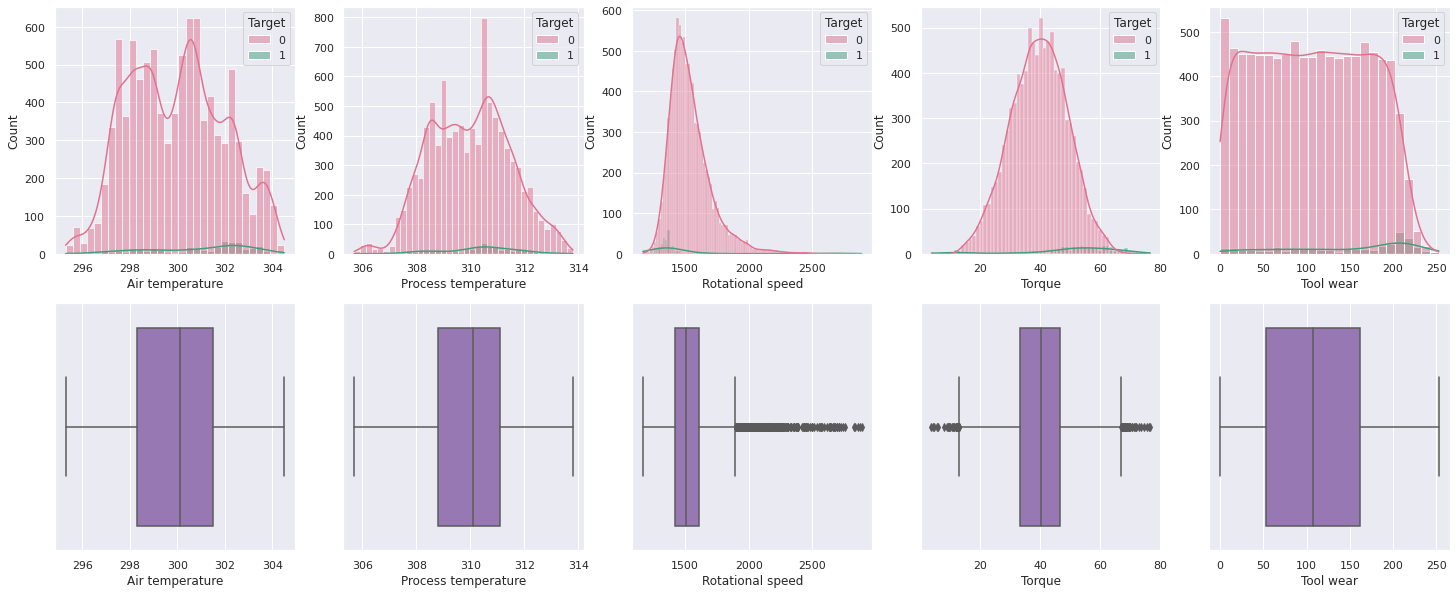

In [29]:
print('----- SKEWNESS ------------')
fig, axes = plt.subplots(2, 5, figsize=[25,10])
j = 0
colors = ['#E1728F', '#409E7D']

for i in ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']:
    sns.histplot(data=df, x=i, kde=True, ax=axes[0,j], hue='Target', palette=colors)
    sns.boxplot(data=df, x=i, ax=axes[1,j], palette=['#976EBD'])
    j+=1
    print('{} skewness = {}'.format(i, round(df[i].skew(), 2)))
print('---------------------------')

* Rotational speed is positively skewed.
* From the boxplots we can see that 'Rotational speed' and 'Torque' have outliers.

Let's check those potential 'outliers' by analyzing the boxplots:


In [30]:
# Function to calculate the maximum and minumum value from the boxplot
def maximum_box(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    maximum = Q3 + 1.5*IQR
    minimum = Q1 - 1.5*IQR
    return maximum, minimum

for i in ['L', 'M', 'H']:
    df_product_type = df[df['Type'] == i]
    max_rotational_speed, min_rotational_speed = maximum_box(df_product_type['Rotational speed'])
    max_torque, min_torque = maximum_box(df_product_type['Torque'])
    print('Values from boxplot for type product ' + i + ':')
    print(f'Maximum torque value: {round(max_torque,2)}')
    print(f'Minimum torque value: {round(min_torque,2)}')
    print(f'Maximum rotational speed value: {round(max_rotational_speed,2)}')
    print(f'Minimum rotational speed value: {round(min_rotational_speed,2)}')
    print('='*20)

Values from boxplot for type product L:
Maximum torque value: 67.2
Minimum torque value: 12.8
Maximum rotational speed value: 1894.0
Minimum rotational speed value: 1142.0
Values from boxplot for type product M:
Maximum torque value: 67.05
Minimum torque value: 13.05
Maximum rotational speed value: 1895.75
Minimum rotational speed value: 1137.75
Values from boxplot for type product H:
Maximum torque value: 66.96
Minimum torque value: 12.66
Maximum rotational speed value: 1894.38
Minimum rotational speed value: 1143.38


**Insight:** The operational range for torque and rotational speed are similar for all product types.

Values above the maximum and below the minimum might be outliers, but not necessarily. 

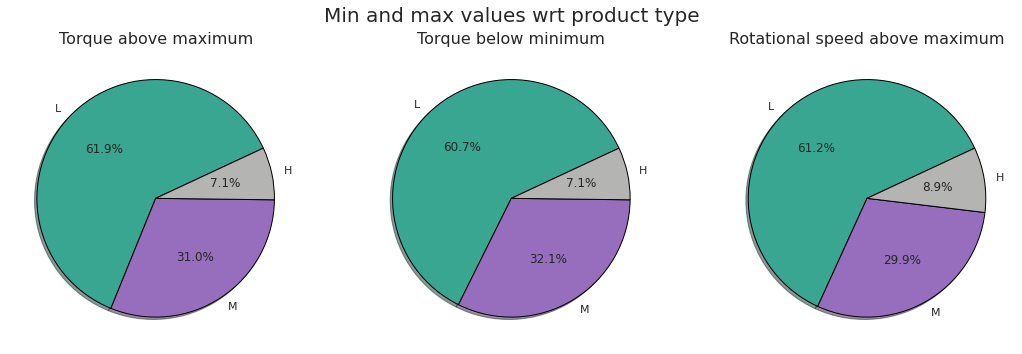

In [31]:
max_rotational_speed, min_rotational_speed = maximum_box(df['Rotational speed'])
max_torque, min_torque = maximum_box(df['Torque'])

max_torque_values = df[df['Torque'] >= max_torque]['Type'].value_counts()  # Torque values above the boxplot maximum
min_torque_values = df[df['Torque'] <= min_torque]['Type'].value_counts()  # Torque values below the boxplot minimum
max_rotational_speed_values = df[df['Rotational speed'] >= max_rotational_speed]['Type'].value_counts()  # Rotational spede values above the boxplot maximum

fig, axes = plt.subplots(1,3, figsize=[15,5])
fig.suptitle('Min and max values wrt product type', fontsize=20)
plt.rcParams['axes.titlesize'] = 16
axes.flatten()
j=0
colors = ['#39A692', '#976EBD', '#B4B5B2']

for i in [max_torque_values, min_torque_values, max_rotational_speed_values]:
    axes[j].pie(i, labels=['L', 'M', 'H'], colors=colors,
        autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25)
    j+=1

axes[0].set_title('Torque above maximum')
axes[1].set_title('Torque below minimum')
axes[2].set_title('Rotational speed above maximum')
plt.tight_layout()

**Insight:** The values above the maximum and below the minimum are not highly correlated with the product type. The proportion of the pies is similar to the 60-30-10 proportion of the entire dataset.

However, there are proportionally slightly more values for L products and less for H across the three scenarios.

In [32]:
total_max_min_values = max_torque_values.sum() + min_torque_values.sum() + max_rotational_speed_values.sum()  # Total of instance under and above the minimum and maximum threshold from the boxplot, respectively.
ratio = total_max_min_values/df.shape[0]  # Percetange of these values with respect to the entire dataset
print('Percentage of values under and above the minimum and maximum threshold from the boxplot: {}'.format(ratio))

Percentage of values under and above the minimum and maximum threshold from the boxplot: 0.048932116715130855


**Insight:** 4.87% of the instances could be considered as ouliers using the boxplot method.

<span style="color:#26488F; font-size:28px; font-weight: bold;">  Data Preprocessing </span>

In [33]:
columns_failure_type = df['Failure Type'].unique().tolist()

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Ordinal Encoding </span>

In [34]:
# Pass on the categorical values
ord_enc = OrdinalEncoder(categories=[['L', 'M', 'H'], columns_failure_type])

# Fit and transform the data for feature 'Type' and target 'Failure Type'
new_dat = ord_enc.fit_transform(df[['Type', 'Failure Type']])
new_dat
df.drop(['Type', 'Failure Type'], axis=1, inplace=True)

new_df = pd.DataFrame(new_dat, 
                      index=df.index, 
                      columns=['Type', 'Failure Type'])

df = pd.concat([df, new_df], axis=1)

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Scaling data </span>

Since 'Rotational spede' and 'Torque' have some outliers, I am going to use RobustScaler:

In [35]:
df_scaled = df.copy()

# Scaling Rotational speed and torque with robust scaler:
columns = ['Rotational speed', 'Torque']
scaler = RobustScaler()
features_scaled = scaler.fit_transform(df[columns])
features_scaled = pd.DataFrame(features_scaled, columns=columns)
df_scaled.drop(columns, axis=1, inplace=True)
df_scaled = pd.concat([df_scaled,features_scaled], axis=1)

df_scaled.head(5)

,Air temperature,Process temperature,Tool wear,Target,Type,Failure Type,Rotational speed,Torque
0,298.1,308.6,0,0,1.0,0.0,0.253968,0.200000
1,298.2,308.7,3,0,0.0,0.0,-0.502646,0.459259
2,298.1,308.5,5,0,0.0,0.0,-0.026455,0.688889
3,298.2,308.6,7,0,0.0,0.0,-0.370370,-0.044444
4,298.2,308.7,9,0,0.0,0.0,-0.502646,-0.007407


The rest of the features will be scaled with MinMax scaling:

In [36]:
columns = ['Air temperature', 'Process temperature', 'Tool wear']
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(df[columns])
features_scaled = pd.DataFrame(features_scaled, columns=columns)
df_scaled.drop(columns, axis=1, inplace=True)
df_scaled = pd.concat([df_scaled, features_scaled], axis=1)

df_scaled.head()

,Target,Type,Failure Type,Rotational speed,Torque,Air temperature,Process temperature,Tool wear
0,0,1.0,0.0,0.253968,0.200000,0.304348,0.358025,0.000000
1,0,0.0,0.0,-0.502646,0.459259,0.315217,0.370370,0.011858
2,0,0.0,0.0,-0.026455,0.688889,0.304348,0.345679,0.019763
3,0,0.0,0.0,-0.370370,-0.044444,0.315217,0.358025,0.027668
4,0,0.0,0.0,-0.502646,-0.007407,0.315217,0.370370,0.035573


<span style="color:#26488F; font-size:28px; font-weight: bold;">  Modeling with 'Target' variable </span>

As the dataset is unbalanced, I am going to used macro f1 score and ROC AUC score to assess model performance.

First, let's build a model with 'Target'. Hence, we need to remove the other target 'Failure Type' to avoid data leakage.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Stratified Split </span>

In [37]:
X = df_scaled.drop(['Target', 'Failure Type'], axis=1)
y = df_scaled['Target']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

print('Checking the stratified split...')
print('Target proportion in original dataset:')
print(df['Target'].value_counts(normalize=True))

print('Target proportion in y_train dataset:')
print(y_train.value_counts(normalize=True))

print('Target proportion in y_test dataset:')
print(y_test.value_counts(normalize=True))

Checking the stratified split...
Target proportion in original dataset:
0    0.966911
1    0.033089
Name: Target, dtype: float64
Target proportion in y_train dataset:
0    0.966974
1    0.033026
Name: Target, dtype: float64
Target proportion in y_test dataset:
0    0.96672
1    0.03328
Name: Target, dtype: float64


The proportions are similar. Therefore, it was correctly splitted.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Balanced Models </span>

Let's train some base models to check how they perform.

Fitting BalancedRandomForestClassifier(n_jobs=-1, random_state=42)
Cross val roc auc test data: 0.9783
Cross val macro f1 score test data: 0.6154
Cross val macro precision score test data: 0.6063
Cross val macro recall score test data: 0.8646

Fitting BalancedBaggingClassifier(n_jobs=-1, random_state=42)
Cross val roc auc test data: 0.9733
Cross val macro f1 score test data: 0.674
Cross val macro precision score test data: 0.6324
Cross val macro recall score test data: 0.8621

Fitting RUSBoostClassifier(random_state=42)
Cross val roc auc test data: 0.8672
Cross val macro f1 score test data: 0.5933
Cross val macro precision score test data: 0.5908
Cross val macro recall score test data: 0.7481

Fitting EasyEnsembleClassifier(random_state=42)
Cross val roc auc test data: 0.9615
Cross val macro f1 score test data: 0.5825
Cross val macro precision score test data: 0.5941
Cross val macro recall score test data: 0.8006



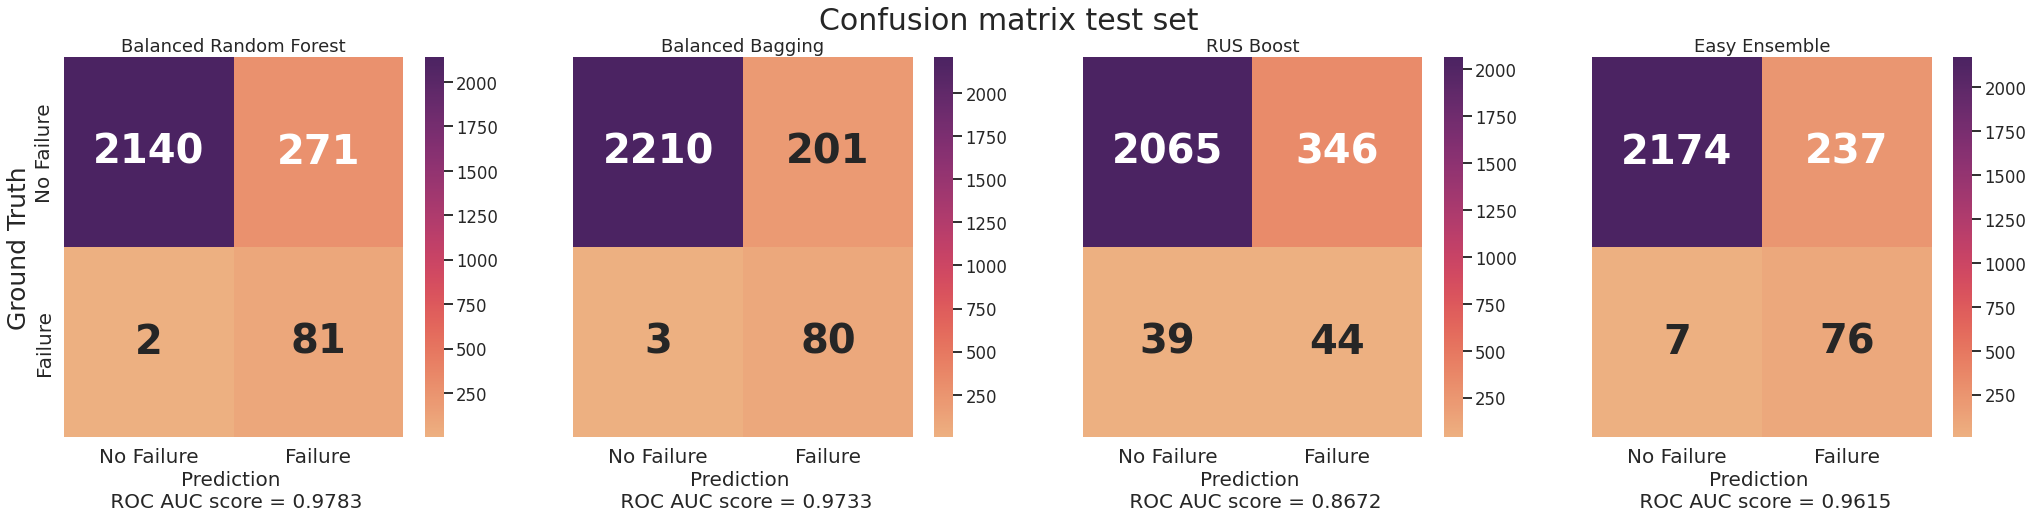

,f1,roc_auc
BalancedBaggingClassifier,0.6740,0.9733
BalancedRandomForestClassifier,0.6154,0.9783
RUSBoostClassifier,0.5933,0.8672
EasyEnsembleClassifier,0.5825,0.9615


In [38]:
from sklearn.model_selection import cross_validate

brfc = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)
bbc = BalancedBaggingClassifier(random_state=42, n_jobs=-1)
RUSB = RUSBoostClassifier(random_state=42)
EEC = EasyEnsembleClassifier(random_state=42)

fig, axes = plt.subplots(1, 4, figsize=[35,7])
fig.suptitle('Confusion matrix test set', fontsize=30)
axes.flatten()
j=0

results_df = pd.DataFrame()

for model in [brfc, bbc, RUSB, EEC]:
    print('Fitting', model)
    model = model.fit(X_train, y_train)

    # Cross validation metrics test data
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
    y_pred = model.predict(X_test)
    scoring = ["f1_macro", "precision_macro", "recall_macro"]
    cross_val_scores = cross_validate(model, X, y, scoring=scoring)
    roc_auc_test_cv = round(cross_val_score(model, X, y, cv=cv, n_jobs=-1, scoring="roc_auc").mean(),4)
    f1_test_cv = round(cross_val_scores["test_f1_macro"].mean(),4)
    precision_test_cv = round(cross_val_scores["test_precision_macro"].mean(),4)
    recall_test_cv = round(cross_val_scores["test_recall_macro"].mean(),4)
    
    # Summary table
    score_df = pd.DataFrame({
                     'f1': round(cross_val_scores["test_f1_macro"].mean(),4),
                     'roc_auc': roc_auc_test_cv},
                     index=[str(model).split('(')[0]])

    results_df = pd.concat([results_df, score_df])

    # Print metrics
    print(f'Cross val roc auc test data: {roc_auc_test_cv}')
    print(f'Cross val macro f1 score test data: {round(cross_val_scores["test_f1_macro"].mean(),4)}')
    print(f'Cross val macro precision score test data: {round(cross_val_scores["test_precision_macro"].mean(),4)}')
    print(f'Cross val macro recall score test data: {round(cross_val_scores["test_recall_macro"].mean(),4)}')
    print()
    
    # Confusion matrix test data
    sns.set_context('talk')
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='flare', annot_kws={"size": 40, "weight": "bold"}, ax=axes[j])

    labels = ['No Failure', 'Failure']
    axes[j].set_xticklabels(labels, fontsize=20)
    axes[j].set_yticklabels(['',''], fontsize=20)
    axes[j].set_xlabel('Prediction \n ROC AUC score = ' + str(roc_auc_test_cv), fontsize=20)
    j += 1

axes[0].set_yticklabels(labels, fontsize=20)
axes[0].set_ylabel('Ground Truth', fontsize=25)
axes[0].set_title('Balanced Random Forest')
axes[1].set_title('Balanced Bagging')
axes[2].set_title('RUS Boost')
axes[3].set_title('Easy Ensemble')
plt.show()

results_df = results_df.sort_values(by='f1', ascending=False)
results_df.round(4)

All results are using cross validation:
- **Balanced Bagging is the best overall model**, with highest f1 score and second highest roc auc.
- Balanced Random Forest has a slightly highest roc auc than Balanced Bagging, but its f1 score is lower.
- Easy Ensemble has a high roc auc thant Balance Bagging, but very low f1 score.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Over and undersampling with Random Forest and Bagging classifiers (Random Search) </span>

Now, let's try using different sampling techniques with random forest and balanced bagging to see if we achieve better performance than the balanced models:

In [39]:
RdFo = RandomForestClassifier(random_state=42, criterion='entropy')
bbc = BaggingClassifier(random_state=42, n_jobs=-1)

OverSamp_1 = RandomOverSampler(random_state=42)
OverSamp_2 = SMOTE(random_state=42, n_jobs=-1)
OverSamp_3 = BorderlineSMOTE(random_state=42, n_jobs=-1)
OverSamp_4 = ClusterCentroids(random_state=42)
OverSamp_5 = TomekLinks(n_jobs=-1)
OverSamp_6 = NearMiss(version=3, n_jobs=-1)

results_df = pd.DataFrame()

OverSamp_list = [OverSamp_1, OverSamp_2, OverSamp_3, OverSamp_4, OverSamp_5, OverSamp_6]

for model in [RdFo, bbc]:
    if model == RdFo:
        grid_param = {'n_estimators': np.arange(10, 160,10),
                       'max_depth': np.arange(10, 110, 10),
                       'min_samples_split': [2, 5, 10]}
        
    else:
        grid_param = {'n_estimators': np.arange(10, 160,10)}
                      
    for samp in OverSamp_list:
        X_train_resampled, y_train_resampled = samp.fit_resample(X_train, y_train)

        random_search = RandomizedSearchCV(model, grid_param, cv=3, n_jobs=-1, scoring=['f1_macro', 'roc_auc'], refit='f1_macro', random_state=42)
        random_search.fit(X_train_resampled, y_train_resampled)
        y_pred = random_search.predict(X_test)
        score_df = pd.DataFrame({'model': str(model).split('(')[0],
                             'f1': f1_score(y_test, y_pred, average="macro"),
                             'auc': roc_auc_score(y_test, y_pred)},
                             index=[str(samp).split('(')[0]])

        params_df = pd.DataFrame(random_search.best_params_, index=[str(samp).split('(')[0]])
        params_df = pd.concat([score_df, params_df], axis=1)
        results_df = pd.concat([results_df, params_df])

results_df = results_df.sort_values(by='f1', ascending=False)
results_df.round(4)

,model,f1,auc,n_estimators,min_samples_split,max_depth
TomekLinks,BaggingClassifier,0.9078,0.8722,120,NaN,NaN
TomekLinks,RandomForestClassifier,0.8828,0.8361,130,5.0,30.0
RandomOverSampler,RandomForestClassifier,0.8805,0.8473,80,5.0,40.0
BorderlineSMOTE,RandomForestClassifier,0.8759,0.9153,110,2.0,100.0
BorderlineSMOTE,BaggingClassifier,0.8618,0.9082,140,NaN,NaN
RandomOverSampler,BaggingClassifier,0.8386,0.8268,20,NaN,NaN
SMOTE,RandomForestClassifier,0.8329,0.9107,30,2.0,100.0
SMOTE,BaggingClassifier,0.8005,0.9009,50,NaN,NaN
NearMiss,BaggingClassifier,0.7674,0.8793,10,NaN,NaN
NearMiss,RandomForestClassifier,0.7287,0.8777,110,2.0,100.0


- Overall, the models have lower roc auc score, but **much higher f1 score**. 
- Tomek's links undersampling on a bagging model had the highest f1 score.
- Bagging classifier using cluster centroids sampling had the highest roc auc score, but the f1 score was too low. 
- In my opinion, Random Forest with Borderline SMOTE have an equilimbrium between f1 roc auc score.

**My takeaway**: the macro f1 score improve dramatically using these sampling techniques! These models might be better compared to the balanced ones 🙃

From now on, I will continue with these two models and the balanced bagging one as well as I will make comparisons between them.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Train chosen models </span>

Let's train a bagging classifier using tomek's links undersampling and a random forest with borderline smote oversampling:

In [40]:
# Bagging Tomek's links undersampling
tomeklinks= TomekLinks(n_jobs=-1)
bag_model = BaggingClassifier(n_estimators=120, random_state=42, n_jobs=-1)
X_train_resampled, y_train_resampled = tomeklinks.fit_resample(X_train, y_train)
bag_model = bag_model.fit(X_train_resampled, y_train_resampled)

# Random forest with borderling oversampling
borderline = BorderlineSMOTE(random_state=42, n_jobs=-1)
rf_model = RandomForestClassifier(n_estimators=110, min_samples_split=2, max_depth=100, random_state=42, criterion='entropy')
X_train_resampled, y_train_resampled = borderline.fit_resample(X_train, y_train)
rf_model = rf_model.fit(X_train_resampled, y_train_resampled)

<span style="color:#26488F; font-size:18px; font-weight: bold;">  Grid Search Balanced Bagging </span>

In [41]:
balanced_bagging_model = BalancedBaggingClassifier(random_state=42, n_jobs=-1)

params = {'n_estimators': range(5,20),
         }
grid_search = GridSearchCV(bbc, params, scoring='f1_macro', cv=3,
                             n_jobs=-1)

grid_search = grid_search.fit(X_train, y_train)

# Best parameters from random search
print(grid_search.best_params_)

# Roc auc score on test set
y_pred_bbc = grid_search.predict(X_test)
print(f'Macro f1 test set: {round(f1_score(y_test, y_pred_bbc, average="macro"),4)}')
print(f'ROC AUC test set: {round(roc_auc_score(y_test, y_pred_bbc),4)}')

{'n_estimators': 17}
Macro f1 test set: 0.905
ROC AUC test set: 0.872


In [42]:
# Let's train the final model
bal_bag_model = BalancedBaggingClassifier(n_estimators=10, random_state=42, n_jobs=-1)
bal_bag_model = bal_bag_model.fit(X_train, y_train)

<span style="color:#26488F; font-size:18px; font-weight: bold;">  Classification report </span>

Let's print out the classification report for every model:

In [43]:
y_pred_bag = bag_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_bal_bag = bal_bag_model.predict(X_test)

print('Classification report Bagging Tomek Links')
print(classification_report(y_test, y_pred_bag))
print('='*53)

print('Classification report Random Forest Borderline SMOTE')
print(classification_report(y_test, y_pred_rf))
print('='*53)

print('Classification report Balanced Bagging')
print(classification_report(y_test, y_pred_bal_bag))


Classification report Bagging Tomek Links
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2411
           1       0.91      0.75      0.82        83

    accuracy                           0.99      2494
   macro avg       0.95      0.87      0.91      2494
weighted avg       0.99      0.99      0.99      2494

Classification report Random Forest Borderline SMOTE
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2411
           1       0.69      0.84      0.76        83

    accuracy                           0.98      2494
   macro avg       0.84      0.92      0.88      2494
weighted avg       0.98      0.98      0.98      2494

Classification report Balanced Bagging
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      2411
           1       0.28      0.96      0.44        83

    accuracy                           0.92     

It can be seen that the Bagging Tomek Links has the higest macro f1 score. 

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Confusion matrix </span>

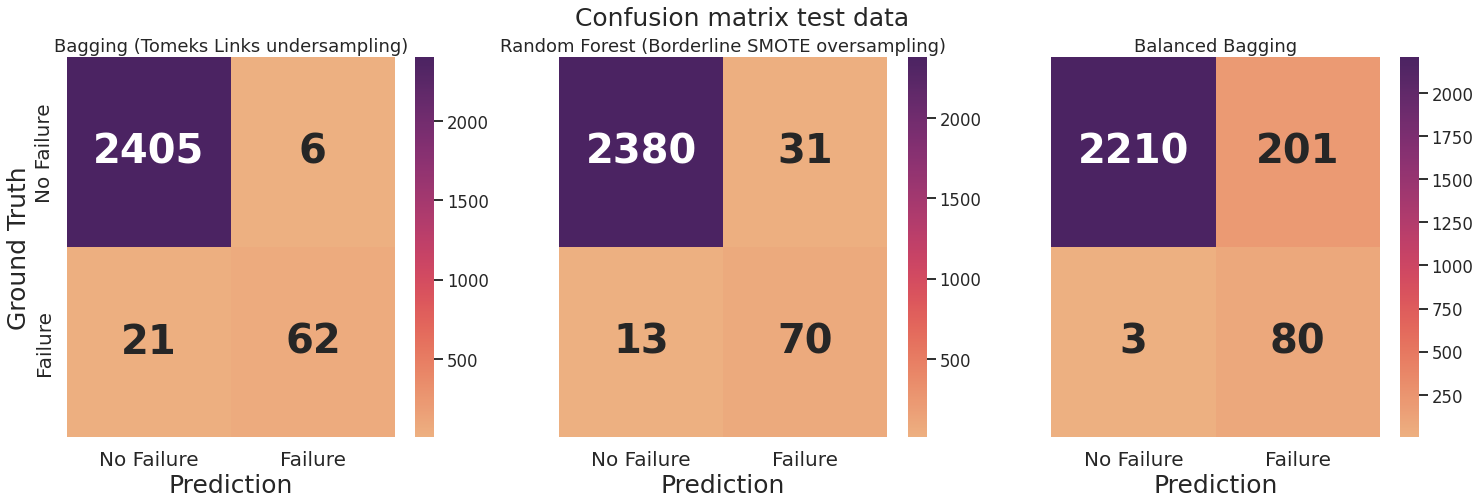

In [44]:
fig, axes = plt.subplots(1, 3, figsize=[25,7])
fig.suptitle('Confusion matrix test data', fontsize=25)
axes.flatten()
j=0

for model in [bag_model, rf_model, bal_bag_model]:
    y_pred = model.predict(X_test)
    # Confusion matrix test data
    sns.set_context('talk')
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='flare', annot_kws={"size": 40, "weight": "bold"}, ax=axes[j])

    labels = ['No Failure', 'Failure']
    axes[j].set_xticklabels(labels, fontsize=20)
    axes[j].set_yticklabels(['',''], fontsize=20)
    axes[j].set_xlabel('Prediction', fontsize=25)
    j += 1

axes[0].set_yticklabels(labels, fontsize=20)
axes[0].set_ylabel('Ground Truth', fontsize=25)
axes[0].set_title('Bagging (Tomeks Links undersampling)')
axes[1].set_title('Random Forest (Borderline SMOTE oversampling)')
axes[2].set_title('Balanced Bagging')
plt.show()

- The current bagging tomek links model does a better job at classifying overall. However, the recall score is low. Consequently, it missed a lot failures (it misclassified 21 failures as no failures).
- The current balanced bagging has a much higher recall; hence it is able to predict almost every failure. However, it has many false positives (it predicted failure 201 times when the machinery was actually working well).

So, what to do next? We can check the roc-auc and precision-recall curves and play around with the decision threshold

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Roc and precision-recall curves </span>


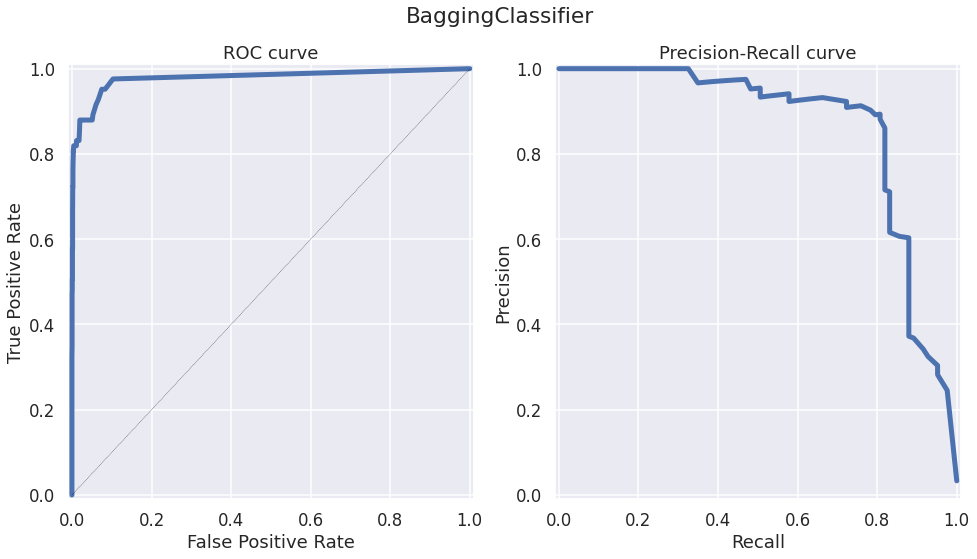

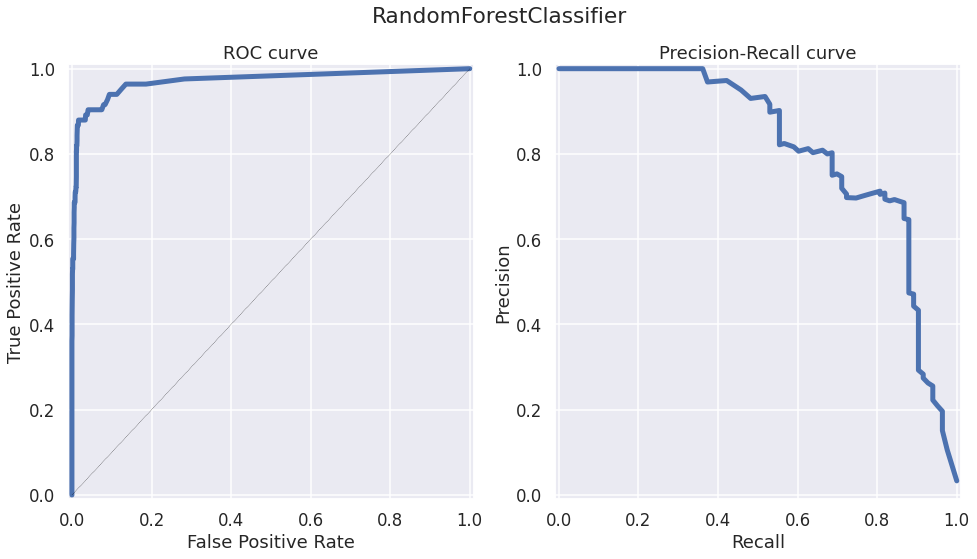

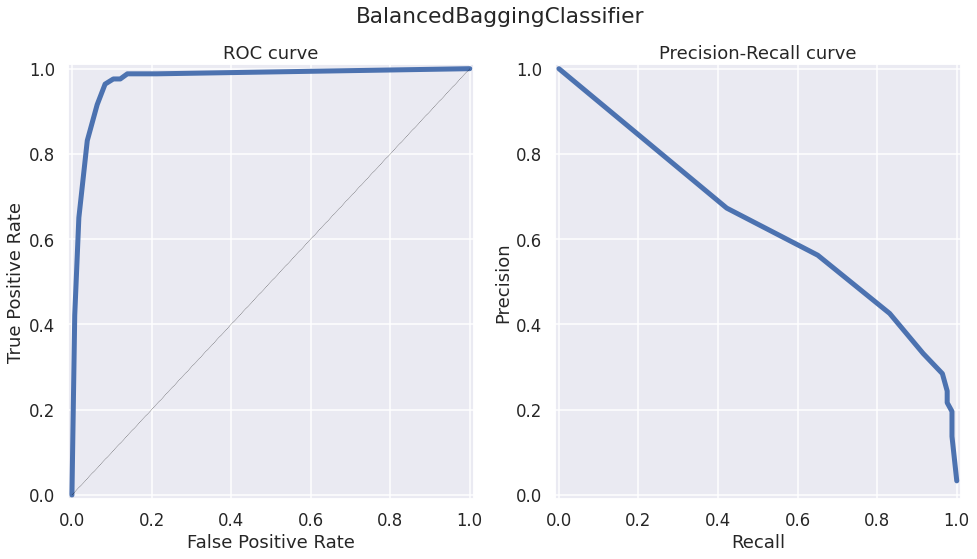

In [45]:
# Roc curve
def roc_prec_recall_curves(model):
    fig, axList = plt.subplots(ncols=2)
    fig.set_size_inches(16, 8)

    y_prob = model.predict_proba(X_test)

    # ROC-AUC curve
    ax = axList[0]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
    ax.plot(fpr, tpr, linewidth=5)
    ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[-.01, 1.01], ylim=[-.01, 1.01],
           title='ROC curve')
    ax.grid(True)

    # Precision-recall curve
    ax = axList[1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
    ax.plot(recall, precision, linewidth=5)
    ax.set(xlabel='Recall', ylabel='Precision',
           xlim=[-.01, 1.01], ylim=[-.01, 1.01],
           title='Precision-Recall curve')
    ax.grid(True)
    plt.suptitle(str(model).split('(')[0])
    
roc_prec_recall_curves(bag_model)
roc_prec_recall_curves(rf_model)
roc_prec_recall_curves(bal_bag_model)
plt.show()

Those plots are using a decision threshold of 0.5 when classiying. As mentioned before, we can play with this number to get a higher recall or precision, considering that there is always a trade-off between them. Let's do that:

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Precision-Recall wrt decision threshold </span>

First, let's check the classification report of the bagigng tomek links model once again:

In [46]:
# Classification report
print(classification_report(y_test, y_pred_bag))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2411
           1       0.91      0.75      0.82        83

    accuracy                           0.99      2494
   macro avg       0.95      0.87      0.91      2494
weighted avg       0.99      0.99      0.99      2494



With this model, for the minority class (failure) we obtain a recall of 0.75 and a precision of 0.91. The algorithm classifies using a threshold of 0.5, meaning that if the probability of a certain instance of being class 1 (failure) is 0.51, it will be classied as failure. On the other hand, if it is less than 0.5 it will be classify as not failure.

We can change this threshold to obtain higher recall or precision scores, depending on what we are trying to achieve. For instace, setting a decision threshold at 0.6 would decrease recall and increase precision, and viceversa.

In the curves below, we can see the trade off between recall and precision (for failure class) by changing the decision threshold.

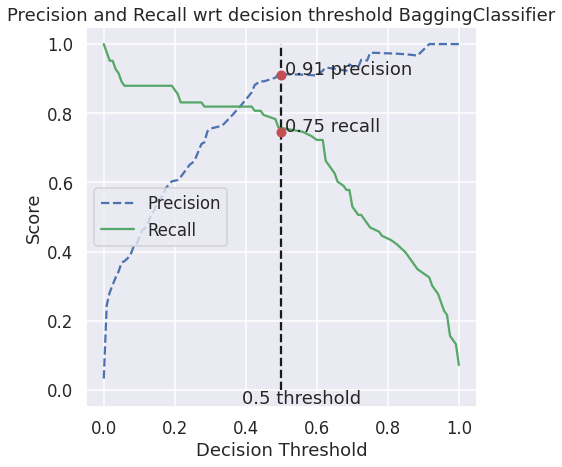

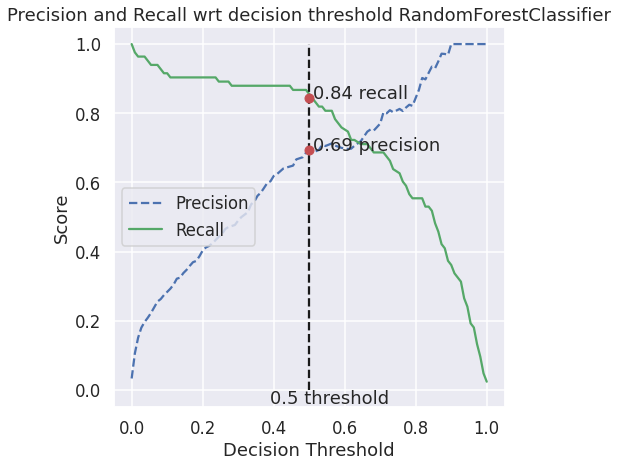

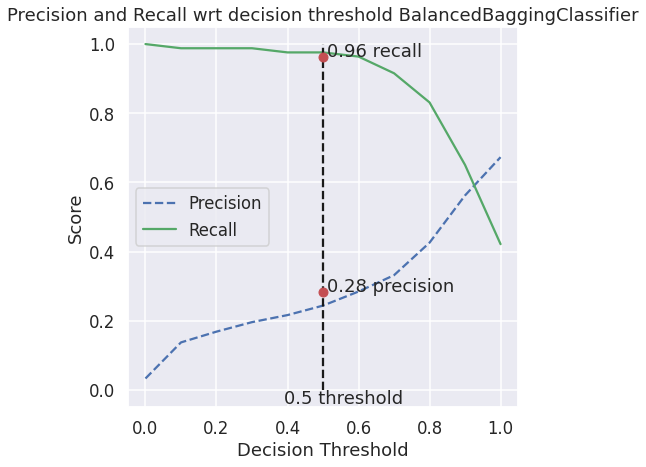

In [47]:
def plot_precision_recall_threshold(model):
    y_pred = model.predict_proba(X_test)[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)
    
    plt.figure(figsize=(7, 7))
    plt.title("Precision and Recall wrt decision threshold " + str(model).split('(')[0])
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot([0.5, 0.5], [0, 1], 'k--')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='center left')
    
    y_pred = model.predict(X_test)
    metrics = precision_recall_fscore_support(y_test, y_pred)
    precision = metrics[0][1]
    recall = metrics[1][1]
    
    # Precision score at 0.5 threshold
    plt.plot(0.5, precision, 'or')
    plt.annotate(f'{precision:.2f} precision', (0.51, precision))
    # Recall score at 0.5 threshold
    plt.plot(0.5, recall, 'or')
    plt.annotate(f'{recall:.2f} recall', (0.51, recall))
    plt.annotate('0.5 threshold', (0.39, -0.04))

plot_precision_recall_threshold(bag_model)
plot_precision_recall_threshold(rf_model)
plot_precision_recall_threshold(bal_bag_model)

plt.show()

- In the bagging tomeks links moel, with a default 0.5 threshold, we obtain a 0.75 recall and 0.91 precision score, just as seen in the classification report above. 
- In the Balanced Bagging, with a 0.5 decision threshold, we obtain a much higher recall (0.96), but lower precision (0.28).


We can move the decision threshold to achieve the desired trade-off of precision-recall. Since we are trying to predict machine failure, the minority class (class failure) should be more important. Hence, we aim at higher recall at the expense of lower precision. In my opinion, it is better to have some false positives than not predict a failure.

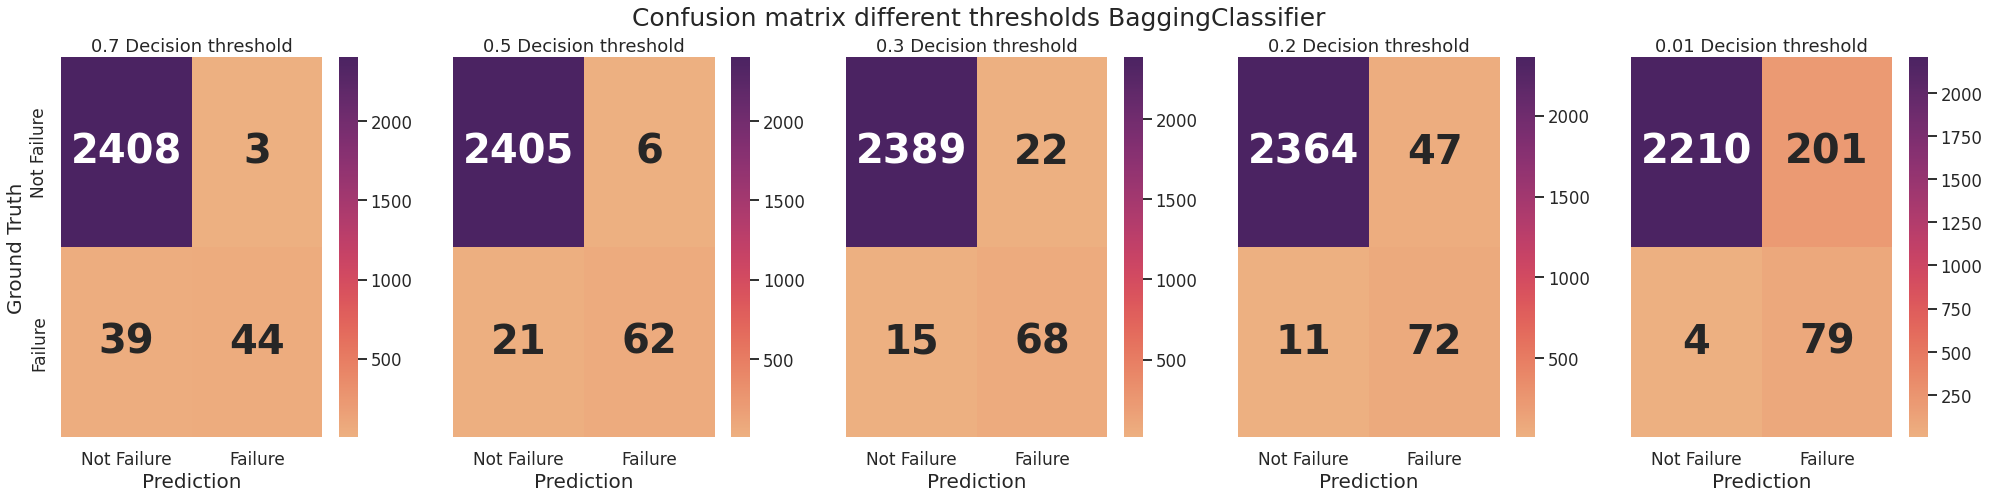

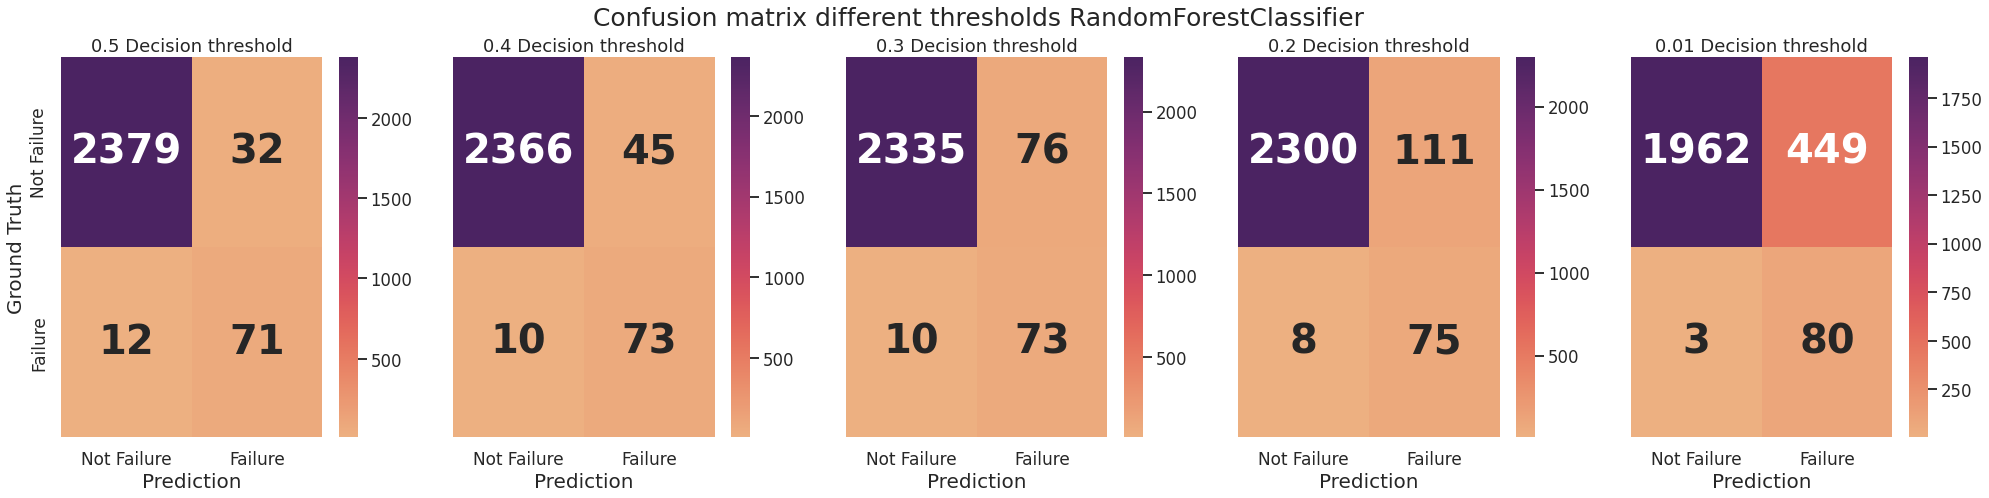

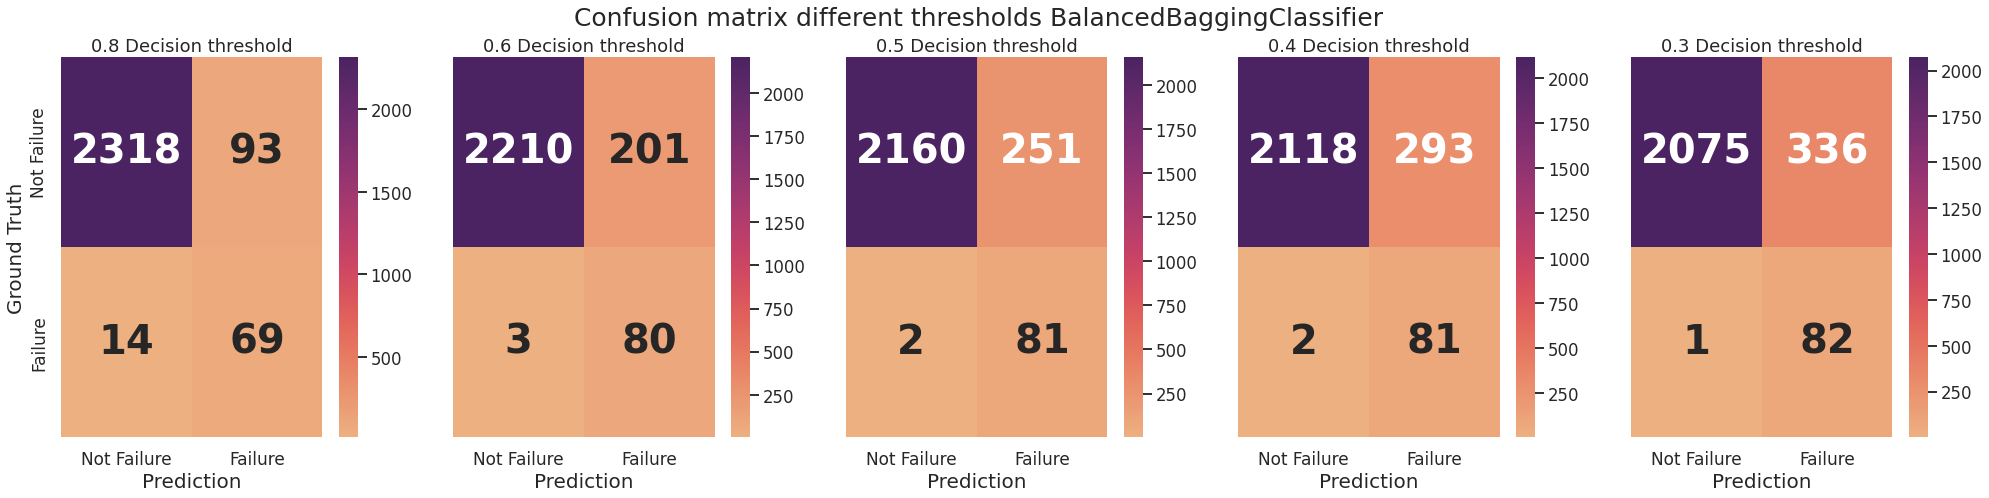

In [48]:
def confusion_matrix_threshold(model, threshold:list):
    # Prediction probabilities with different thresholds
    y_pred_dt = (model.predict_proba(X_test)[:,1] >= threshold[0]).astype(bool).astype(int)
    y_pred_dt_2 = (model.predict_proba(X_test)[:,1] >= threshold[1]).astype(bool).astype(int)
    y_pred_dt_3 = (model.predict_proba(X_test)[:,1] >= threshold[2]).astype(bool).astype(int)
    y_pred_dt_4 = (model.predict_proba(X_test)[:,1] >= threshold[3]).astype(bool).astype(int)
    y_pred_dt_5 = (model.predict_proba(X_test)[:,1] >= threshold[4]).astype(bool).astype(int)
    
    # Confusion matrices with different thresholds
    cm_dt = confusion_matrix(y_test, y_pred_dt)
    cm_dt_2 = confusion_matrix(y_test, y_pred_dt_2)
    cm_dt_3 = confusion_matrix(y_test, y_pred_dt_3)
    cm_dt_4 = confusion_matrix(y_test, y_pred_dt_4)
    cm_dt_5 = confusion_matrix(y_test, y_pred_dt_5)

    # Plotting confusion matrices
    fig, ax = plt.subplots(1,5,figsize=(34,7))
    ax.flatten()
    fig.suptitle('Confusion matrix different thresholds ' + str(model).split('(')[0], fontsize=25)

    sns.heatmap(cm_dt, annot=True, fmt='d', cmap='flare', annot_kws={"size": 40, "weight": "bold"}, ax=ax[0])
    sns.heatmap(cm_dt_2, annot=True, fmt='d', cmap='flare', annot_kws={"size": 40, "weight": "bold"}, ax=ax[1])
    sns.heatmap(cm_dt_3, annot=True, fmt='d', cmap='flare', annot_kws={"size": 40, "weight": "bold"}, ax=ax[2])
    sns.heatmap(cm_dt_4, annot=True, fmt='d', cmap='flare', annot_kws={"size": 40, "weight": "bold"}, ax=ax[3])
    sns.heatmap(cm_dt_5, annot=True, fmt='d', cmap='flare', annot_kws={"size": 40, "weight": "bold"}, ax=ax[4])

    ax[0].set_title(f'{threshold[0]} Decision threshold')
    ax[1].set_title(f'{threshold[1]} Decision threshold')
    ax[2].set_title(f'{threshold[2]} Decision threshold')
    ax[3].set_title(f'{threshold[3]} Decision threshold')
    ax[4].set_title(f'{threshold[4]} Decision threshold')

    labels = ['Not Failure', 'Failure']
    for i in [0,1,2,3,4]:
        ax[i].set_xticklabels(labels, fontsize=17)
        ax[i].set_xlabel('Prediction', fontsize=20)
        ax[i].set_yticklabels(['',''])

    ax[0].set_ylabel('Ground Truth', fontsize=20)
    ax[0].set_yticklabels(labels, fontsize=17)

confusion_matrix_threshold(bag_model, [0.7, 0.5, 0.3, 0.2, 0.01])
confusion_matrix_threshold(rf_model, [0.5, 0.4, 0.3, 0.2, 0.01])
confusion_matrix_threshold(bal_bag_model, [0.8, 0.6, 0.5, 0.4, 0.3])
plt.show()

Let's explain the results...

Decision threshold 0.5:
- Balanced bagging classifier was not able to predict only 2 failures. 251 times classified no failures as failures.
- Bagging Tomek Links was not able to predict 21 failures. But, it misclassified no failures only 6 times. 
- Random forest borderline SMOTE was not able to predict 12 failures. It misclassified no failures 32 times.
    
**Takeaways**:

The bagging tomek links model is not able to reduce the recall on failures lower than 95.18%. Even with a decision threshold of 0.01 (which makes no sense) it still misclassified 4 failures and had 201 false positives. On the other, balanced bagging with a decision threshold of 0.6 is able to have better recall (96.25%) and the same number of false positives (201). Moreover, it is able to reduce the recall down to 98.8% (only 1 misclassified failure) at the expense of increasing the number of positives (336). But, it is the only one of the three models to get this very high recall. 
 

<span style="color:#26488F; font-size:18px; font-weight: bold;">  Conclusions </span>

In my opinion, the experts from the maintenance and manufacturing departments should be the ones who choose the model in accordance with their objectives.
- If they are looking for the highest failure detection possible, they should go with the balanced bagging model, thou they would be sacrificing precision with lots of false positives. 
- If they want a balance between precision and recall, perhaps they could choose between the bagging model 0.4 decision threshold or the random forest model with 0.5  threshold. 
- Maybe they do not care much about predicting every failure, but when they do, they want the highest precision possible. In that case, it would be better to opt for the bagging tomek links classifier with a bit higher decision threshold. 

So, the selection of the model depends on the application and desired outcomes.


<span style="color:#26488F; font-size:22px; font-weight: bold;">  Saving Models </span>

In [49]:
with open("Bagging_binary.pkl","wb") as files:
    pickle.dump(bag_model,files)
with open("RandomForest_binary.pkl","wb") as files:
    pickle.dump(rf_model,files)
with open("BalancedBagging_binary.pkl","wb") as files:
    pickle.dump(bal_bag_model,files)

<span style="color:#26488F; font-size:28px; font-weight: bold;">  Modeling with 'Failure Type' target </span>

Now, let's treat the problem as a multiclass one.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Stratified Split </span>

In [50]:
X = df.drop(['Target', 'Failure Type'], axis=1)
y = df['Failure Type']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

print('Checking the stratified split...')
print('Target proportion in original dataset:')
print(df['Failure Type'].value_counts(normalize=True))

print('Target proportion in y_train dataset:')
print(y_train.value_counts(normalize=True))

print('Target proportion in y_test dataset:')
print(y_test.value_counts(normalize=True))

Checking the stratified split...
Target proportion in original dataset:
0.0    0.966911
4.0    0.011230
1.0    0.009526
3.0    0.007821
2.0    0.004512
Name: Failure Type, dtype: float64
Target proportion in y_train dataset:
0.0    0.966974
4.0    0.011231
1.0    0.009493
3.0    0.007755
2.0    0.004546
Name: Failure Type, dtype: float64
Target proportion in y_test dataset:
0.0    0.966720
4.0    0.011227
1.0    0.009623
3.0    0.008019
2.0    0.004411
Name: Failure Type, dtype: float64


The proportions are similar. Therefore, it was correctly splitted.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Balanced Models </span>

Fitting BalancedRandomForestClassifier(n_jobs=-1, random_state=42)
ROC AUC test set: 0.9805849324677449

Fitting BalancedBaggingClassifier(n_jobs=-1, random_state=42)
ROC AUC test set: 0.9655364264073679

Fitting RUSBoostClassifier(random_state=42)
ROC AUC test set: 0.9278680487815427

Fitting EasyEnsembleClassifier(random_state=42)
ROC AUC test set: 0.9348984745836427



Text(0.5, 1.0, 'Easy Ensemble')

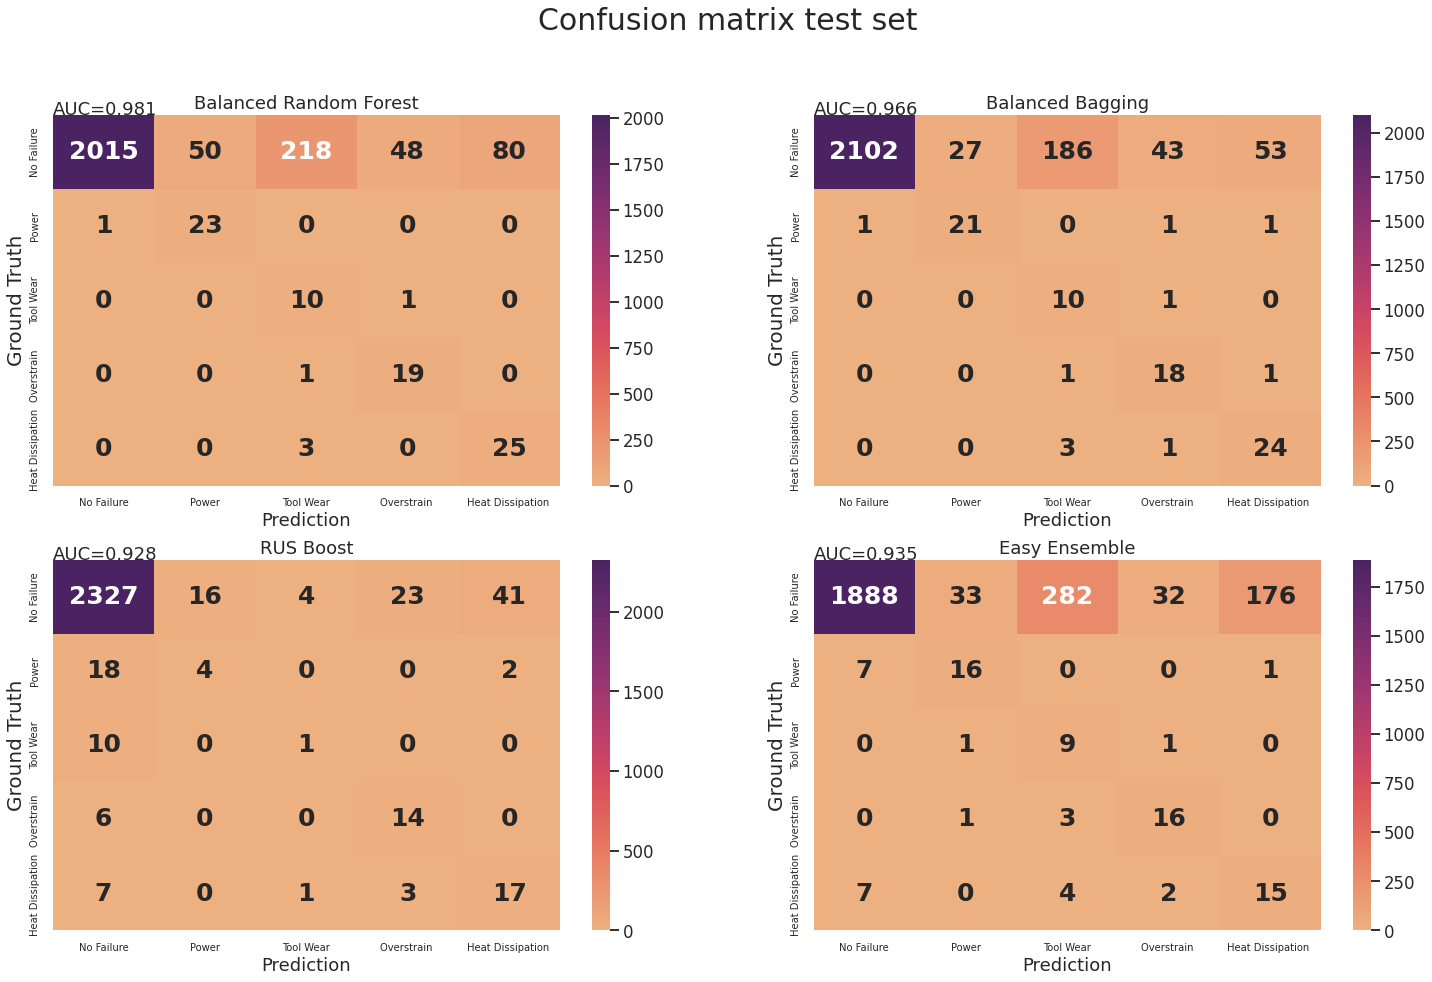

In [51]:
brfc = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)
bbc = BalancedBaggingClassifier(random_state=42, n_jobs=-1)
RUSB = RUSBoostClassifier(random_state=42)
EEC = EasyEnsembleClassifier(random_state=42)

fig, axes = plt.subplots(2, 2, figsize=[25,15])
fig.suptitle('Confusion matrix test set', fontsize=30)
# axes.flatten()
i=0
j=0
for model in [brfc, bbc, RUSB, EEC]:
    print('Fitting', model)
    model = model.fit(X_train, y_train)

    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25)
    
    y_pred = model.predict(X_test)
    y_preb_probs = model.predict_proba(X_test)

    print(f'ROC AUC test set: {roc_auc_score(y_test, y_preb_probs, average="macro", multi_class="ovr")}')

    print()
    
    if j == 2:
        j = 0
        i = 1
        
    sns.set_context('talk')
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='flare', annot_kws={"size": 25, "weight": "bold"}, ax=axes[i,j])

    labels =  ['No Failure',
               'Power',
               'Tool Wear',
               'Overstrain ',
               'Heat Dissipation ']
    axes[i,j].set_xticklabels(labels, fontsize=10);
    axes[i,j].set_yticklabels(labels, fontsize=10);
    axes[i,j].set_ylabel('Ground Truth', fontsize=20);
    axes[i,j].set_xlabel('Prediction')
    axes[i,j].annotate('AUC=' + str(round(roc_auc_score(y_test, y_preb_probs, average="macro", multi_class="ovr"),3)), xy=[0,0])
    j += 1

axes[0,0].set_title('Balanced Random Forest')
axes[0,1].set_title('Balanced Bagging')
axes[1,0].set_title('RUS Boost')
axes[1,1].set_title('Easy Ensemble')

Again, Balanced Random Forest and Balanced Bagging outpeformed the other two algorithms.

<span style="color:#26488F; font-size:18px; font-weight: bold;">  Balanced Random Forest (Random Search) </span> 

In [52]:
brfc = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)

params = {'n_estimators': np.arange(150, 400, 50),
               'max_depth': np.arange(10, 50, 10),
               'min_samples_split': [2, 4, 6],
               'criterion': ['gini', 'entropy'],
               'min_samples_leaf': [1, 2, 3, 4],
               'max_features': ['sqrt', 'log2']
            }

random_search = RandomizedSearchCV(brfc, params, cv=3,
                                   n_iter=100, random_state=42, n_jobs=-1)

random_search = random_search.fit(X_train, y_train)

# Best parameters from random search
print(random_search.best_params_)

{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini'}


<span style="color:#26488F; font-size:18px; font-weight: bold;">  Balanced Random Forest (Grid Search) </span>

In [53]:
brfc = BalancedRandomForestClassifier(max_features='sqrt', random_state=42, n_jobs=-1)

params = {'n_estimators': [40, 50, 60],
               'max_depth': [15, 20, 25],
               'min_samples_leaf': [1, 2]
            }

grid_search = GridSearchCV(brfc, params, cv=cv,
                           n_jobs=-1)

grid_search = grid_search.fit(X_train, y_train)
# Best parameters from grid search
grid_search.best_params_

{'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 40}

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Training both models with the best hyperparameters </span>

In [54]:
# Balanced Random Forest
brfc = BalancedRandomForestClassifier(n_estimators=40, max_depth=15, min_samples_leaf=1,
                                     max_features='sqrt', random_state=42, n_jobs=-1)

brfc = brfc.fit(X_train, y_train)
y_pred_brfc = brfc.predict(X_test)
y_pred_probs_brfc = brfc.predict_proba(X_test)

# Balanced Bagging
bbc = BalancedBaggingClassifier(n_estimators=13, random_state=42, n_jobs=-1)
bbc = bbc.fit(X_train, y_train)
y_pred_bbc = bbc.predict(X_test)
y_pred_probs_bbc = bbc.predict_proba(X_test)

<span style="color:#26488F; font-size:18px; font-weight: bold;">  Scores </span>

In [55]:
# Balanced Random Forest scores
print('Results for Balanced Random Forest')
print(classification_report(y_test, y_pred_brfc))
print('Macro roc auc (OvR): ', roc_auc_score(y_test, y_pred_probs_brfc, average="macro", multi_class="ovr"))
print('='*53)
print()

# Balanced Bagging scores
print('Results for Balanced Bagging')
print(classification_report(y_test, y_pred_bbc))
print('Macro roc auc (OvR): ', roc_auc_score(y_test, y_pred_probs_bbc, average="macro", multi_class="ovr"))

Results for Balanced Random Forest
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91      2411
         1.0       0.36      1.00      0.53        24
         2.0       0.04      0.91      0.08        11
         3.0       0.24      0.95      0.38        20
         4.0       0.24      0.79      0.36        28

    accuracy                           0.84      2494
   macro avg       0.38      0.90      0.45      2494
weighted avg       0.97      0.84      0.90      2494

Macro roc auc (OvR):  0.9796886869386336

Results for Balanced Bagging
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93      2411
         1.0       0.47      0.96      0.63        24
         2.0       0.05      0.91      0.09        11
         3.0       0.31      0.90      0.46        20
         4.0       0.28      0.82      0.41        28

    accuracy                           0.87      2494
   macro avg       0.42  

**Conclusion:** Balance Random Forest has a slightly lower ROC AUC (OvR) but higher f1 score (both macro and weighted).
Let's take a look at the confusion matrices:

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Confusion matrix </span>

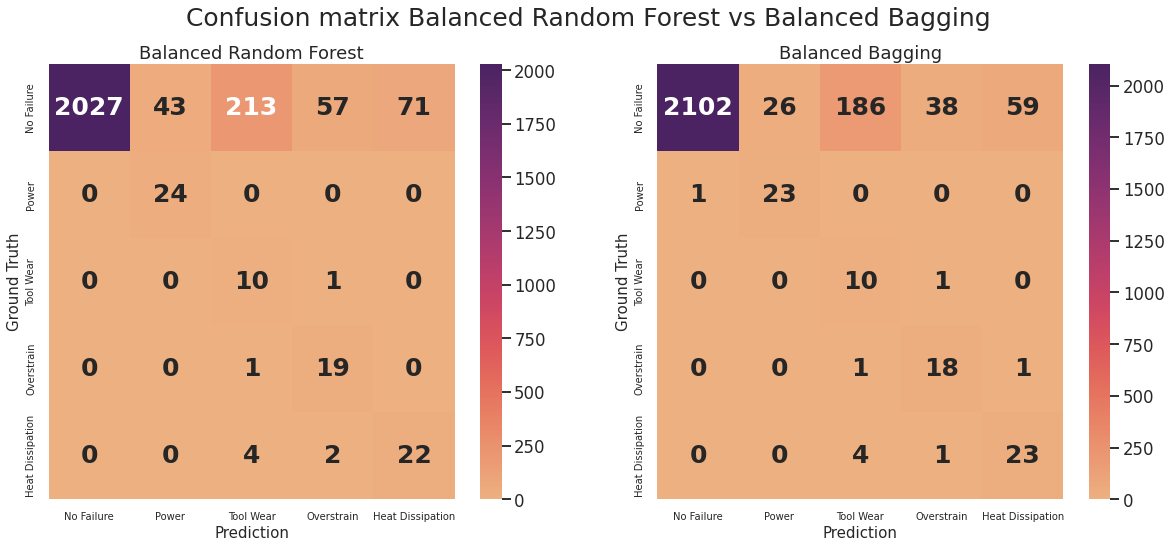

In [56]:
cm_brfc = confusion_matrix(y_test, y_pred_brfc)
cm_bbc = confusion_matrix(y_test, y_pred_bbc)

# Plotting confusion matrices
fig, ax = plt.subplots(1,2,figsize=(20,8))
ax.flatten()
fig.suptitle('Confusion matrix Balanced Random Forest vs Balanced Bagging', fontsize=25)

sns.heatmap(cm_brfc, annot=True, fmt='d', cmap='flare', annot_kws={"size": 25, "weight": "bold"}, ax=ax[0])
sns.heatmap(cm_bbc, annot=True, fmt='d', cmap='flare', annot_kws={"size": 25, "weight": "bold"}, ax=ax[1])

ax[0].set_title('Balanced Random Forest')
ax[1].set_title('Balanced Bagging')

labels =  ['No Failure',
           'Power',
           'Tool Wear',
           'Overstrain',
           'Heat Dissipation']

for i in [0,1]:
    ax[i].set_xticklabels(labels, fontsize=10);
    ax[i].set_yticklabels(labels, fontsize=10);
    ax[i].set_ylabel('Ground Truth', fontsize=15);
    ax[i].set_xlabel('Prediction', fontsize=15)

<span style="color:#26488F; font-size:18px; font-weight: bold;">  Conclusions </span>

The performance of both models is really close to each other. 
* There is a bit of a tendency to misclassify Heat Dissipation Failure as Tool Wear Failure.
* Balanced Random Forest is able to detect every failure, although sometimes it misclassifies them. Balanced Bagging was not able to detect one power failure. 

I would pick Balanced Bagging classifier for the following reasons:
* The recall scores are slightly lower. But, we can see in the confusion matrix that the precision for each class is higher.
* Since we know that sometimes Heat Dissipation Failures are classified as Tool Wear Failures, we might take the appropriate actions to deal with such maintenance in real-world applications. In other words, if we predict a Heat Dissipation Failure, we might check the tool wear as well.
* However, such a decision should be supported by the maintenance and manufacturing teams. It is difficult to pick without taking into account the real application. As mentioned before, they might want to get higher precision and reducing recall. 

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Save Model </span>

In [57]:
with open("BalBagging_multiclass.pkl","wb") as files:
    pickle.dump(bbc,files)
with open("BalRandomForest_multiclass.pkl","wb") as files:
    pickle.dump(brfc,files)

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Comments </span>

I hope the analysis was useful to you. Please feel free to leave a comment 😊